In [2]:
import sys, os, random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import random


In [3]:
sys.path.append(
    "/Users/wiegerscheurer/repos/physicspred"
)  # To enable importing from repository folders


from functions.utilities import ordinal_sample, bellshape_sample
from functions.physics import _rotate_90, _dir_to_vec, _vec_to_dir, _flip_dir
from functions.utilities import check_balance, create_balanced_trial_design, build_design_matrix, determine_sequence
from functions.analysis import (get_precision, 
                                get_data, 
                                get_false_negatives,
                                get_false_positives,
                                get_true_positives,
                                get_true_negatives,
                                filter_condition,
                                get_f1_score, 
                                get_rt, 
                                get_accuracy,
                                get_hit_rate,)


In [ ]:
# all_sub_names = ["wolpert", "wunger","scheur", "hendrik", "willem", "ikzelf", "melvin", "paulo", "yifan", "ann", "qifei", "mingyao", "bilge", "yanni", "eva"]
# all_sub_names = ["002634"]
sub_stack = pd.DataFrame()

# for sub_idx, sub in enumerate(all_sub_names):
    this_sub = get_data(subject=f"sub-{sub}", task="ball_hue")
    sub_stack = pd.concat([sub_stack, this_sub])
    
sub_stack.reset_index(inplace=True, drop=True)
# sub_stack

In [8]:
sub_stack = pd.DataFrame()


sub_stack = get_data(subject=None, task="ball_hue")
    # sub_stack = pd.concat([sub_stack, this_sub])

# sub_stack.reset_index(inplace=True, drop=True)


In [46]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from numpy.polynomial.polynomial import polyfit

def create_psychometric_plots(data, title=None, prob_ylim=None, rt_ylim=None, 
                              prob_poly_fit=None, rt_poly_fit=None, split_hypotheses=False):
    """
    Create two psychometric plots with customizable features.
    
    Parameters:
    -----------
    data : pandas.DataFrame
        DataFrame containing the columns 'ball_color_change', 'response', and 'rt'
    title : str, optional
        Custom title for the overall figure
    prob_ylim : tuple, optional
        Custom y-axis range for probability plot (min, max)
    rt_ylim : tuple, optional
        Custom y-axis range for reaction time plot (min, max)
    prob_poly_fit : int or None, optional
        Degree of polynomial to fit to probability data (None for no fit)
    rt_poly_fit : int or None, optional
        Degree of polynomial to fit to reaction time data (None for no fit)
    split_hypotheses : bool, optional
        Whether to split the data into four hypotheses using filter_condition
    """
    # Figure setup
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
    plt.tight_layout(pad=4)
    
    if not split_hypotheses:
        # Original implementation for a single dataset
        # Extract unique values of ball_color_change and ensure they are in order
        color_changes = sorted(data['ball_color_change'].unique())
        
        # Convert color changes to numeric for polynomial fitting
        # (necessary if they're stored as strings)
        x_numeric = np.array([float(x) for x in color_changes])
        
        # Calculate probability of "lighter" response for each ball_color_change value
        prob_lighter = []
        for change in color_changes:
            subset = data[data['ball_color_change'] == change]
            prob = (subset['response'] == 'lighter').mean()
            prob_lighter.append(prob)
        
        # Calculate mean reaction time for each ball_color_change value
        mean_rt = []
        rt_error = []  # for standard error
        for change in color_changes:
            subset = data[data['ball_color_change'] == change]
            mean_rt.append(subset['rt'].mean())
            rt_error.append(subset['rt'].std() / np.sqrt(len(subset)))
        
        # Plot 1: Probability of "lighter" response
        ax1.plot(color_changes, prob_lighter, 'o-', color='blue', markersize=8, label='Data')
        
        # Add polynomial fit if requested
        if prob_poly_fit is not None:
            # Create a more fine-grained x for smooth curve
            x_fit = np.linspace(min(x_numeric), max(x_numeric), 100)
            
            # Fit polynomial of specified degree
            coefs = polyfit(x_numeric, prob_lighter, prob_poly_fit)
            y_fit = np.polyval(coefs, x_fit)
            
            # Plot fitted curve
            ax1.plot(x_fit, y_fit, 'r--', linewidth=2, 
                     label=f'{prob_poly_fit}-degree polynomial fit')
        
        # Plot 2: Reaction time
        ax2.errorbar(color_changes, mean_rt, yerr=rt_error, fmt='o-', color='green', 
                    markersize=8, capsize=5, label='Data')
        
        # Add polynomial fit if requested for RT data
        if rt_poly_fit is not None:
            # Create a more fine-grained x for smooth curve
            x_fit = np.linspace(min(x_numeric), max(x_numeric), 100)
            
            # Fit polynomial of specified degree
            coefs = polyfit(x_numeric, mean_rt, rt_poly_fit)
            y_fit = np.polyval(coefs, x_fit)
            
            # Plot fitted curve
            ax2.plot(x_fit, y_fit, 'r--', linewidth=2, 
                     label=f'{rt_poly_fit}-degree polynomial fit')
        
        # Add labels for number of trials per condition
        for i, change in enumerate(color_changes):
            count = len(data[data['ball_color_change'] == change])
            ax1.annotate(f'n={count}', xy=(change, prob_lighter[i]), 
                        xytext=(0, 10), textcoords='offset points', 
                        ha='center', va='bottom', fontsize=8)
    
    else:
        # Implementation for split hypotheses
        # Get data for each hypothesis
        cc = filter_condition(data, True, True)
        ci = filter_condition(data, True, False)
        ic = filter_condition(data, False, True)
        ii = filter_condition(data, False, False)
        
        # Define colors and labels for each hypothesis
        hypotheses = [
            (cc, 'CC', 'blue'),
            (ci, 'CI', 'green'),
            (ic, 'IC', 'red'),
            (ii, 'II', 'purple')
        ]
        
        # Find the common set of color changes across all hypotheses
        all_changes = set()
        for hyp_data, _, _ in hypotheses:
            all_changes.update(hyp_data['ball_color_change'].unique())
        color_changes = sorted(all_changes)
        
        # Convert color changes to numeric for polynomial fitting
        x_numeric = np.array([float(x) for x in color_changes])
        
        # Plot for each hypothesis
        for hyp_data, label, color in hypotheses:
            hyp_color_changes = sorted(hyp_data['ball_color_change'].unique())
            hyp_x_numeric = np.array([float(x) for x in hyp_color_changes])
            
            # Skip if no data for this hypothesis
            if len(hyp_color_changes) == 0:
                continue
                
            # Calculate probability of "lighter" response
            prob_lighter = []
            for change in hyp_color_changes:
                subset = hyp_data[hyp_data['ball_color_change'] == change]
                if len(subset) > 0:
                    prob = (subset['response'] == 'lighter').mean()
                    prob_lighter.append(prob)
                else:
                    prob_lighter.append(np.nan)
            
            # Calculate mean reaction time and error
            mean_rt = []
            rt_error = []
            for change in hyp_color_changes:
                subset = hyp_data[hyp_data['ball_color_change'] == change]
                if len(subset) > 0:
                    mean_rt.append(subset['rt'].mean())
                    rt_error.append(subset['rt'].std() / np.sqrt(len(subset)))
                else:
                    mean_rt.append(np.nan)
                    rt_error.append(np.nan)
            
            # Plot probability data
            ax1.plot(hyp_color_changes, prob_lighter, 'o-', color=color, 
                    markersize=6, label=f'Hypothesis {label}')
            
            # Add polynomial fit if requested
            if prob_poly_fit is not None and len(hyp_color_changes) > prob_poly_fit:
                try:
                    # Create a more fine-grained x for smooth curve
                    x_fit = np.linspace(min(hyp_x_numeric), max(hyp_x_numeric), 100)
                    
                    # Fit polynomial of specified degree
                    valid_indices = ~np.isnan(prob_lighter)
                    if sum(valid_indices) > prob_poly_fit:
                        coefs = polyfit(hyp_x_numeric[valid_indices], 
                                        np.array(prob_lighter)[valid_indices], 
                                        prob_poly_fit)
                        y_fit = np.polyval(coefs, x_fit)
                        
                        # Plot fitted curve
                        ax1.plot(x_fit, y_fit, '--', color=color, linewidth=1.5, 
                                alpha=0.7, label=f'{label} {prob_poly_fit}-deg fit')
                except:
                    # Skip polynomial fitting if there's an error (e.g., not enough data points)
                    pass
            
            # Plot reaction time data
            ax2.errorbar(hyp_color_changes, mean_rt, yerr=rt_error, fmt='o-', 
                        color=color, markersize=6, capsize=4, 
                        label=f'Hypothesis {label}')
            
            # Add polynomial fit if requested for RT data
            if rt_poly_fit is not None and len(hyp_color_changes) > rt_poly_fit:
                try:
                    # Create a more fine-grained x for smooth curve
                    x_fit = np.linspace(min(hyp_x_numeric), max(hyp_x_numeric), 100)
                    
                    # Fit polynomial of specified degree
                    valid_indices = ~np.isnan(mean_rt)
                    if sum(valid_indices) > rt_poly_fit:
                        coefs = polyfit(hyp_x_numeric[valid_indices], 
                                        np.array(mean_rt)[valid_indices], 
                                        rt_poly_fit)
                        y_fit = np.polyval(coefs, x_fit)
                        
                        # Plot fitted curve
                        ax2.plot(x_fit, y_fit, '--', color=color, linewidth=1.5,
                                alpha=0.7, label=f'{label} {rt_poly_fit}-deg fit')
                except:
                    # Skip polynomial fitting if there's an error
                    pass
    
    # Common settings for both plots
    ax1.set_xlabel('Ball Color Change')
    ax1.set_ylabel('Probability of "Lighter" Response')
    ax1.set_title('Psychometric Function: Probability of "Lighter" Response')
    
    # Set custom y-axis limits if provided
    if prob_ylim:
        ax1.set_ylim(prob_ylim)
    else:
        ax1.set_ylim(0, 1)  # Default range for probability
    
    ax1.grid(True, alpha=0.3)
    ax1.legend(loc='best')
    
    # Add horizontal line at 0.5 probability for reference
    ax1.axhline(y=0.5, color='gray', linestyle='--', alpha=0.7)
    
    ax2.set_xlabel('Ball Color Change')
    ax2.set_ylabel('Reaction Time (ms)')
    ax2.set_title('Reaction Time by Ball Color Change')
    
    # Set custom y-axis limits if provided
    if rt_ylim:
        ax2.set_ylim(rt_ylim)
    
    ax2.grid(True, alpha=0.3)
    ax2.legend(loc='best')
    
    # Set custom title if provided
    if title:
        plt.suptitle(title, fontsize=16)
    else:
        plt.suptitle('Psychometric Analysis of Ball Hue Task', fontsize=16)
    
    plt.savefig('psychometric_plots.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    return fig

# Example usage:
# create_psychometric_plots(
#     testdf, 
#     title="Custom Psychometric Analysis",
#     prob_ylim=(0, 1),
#     rt_ylim=(500, 1000),
#     prob_poly_fit=2,  # Quadratic fit for probability
#     rt_poly_fit=None,  # No fit for reaction time
#     split_hypotheses=True  # Split data by hypotheses
# )

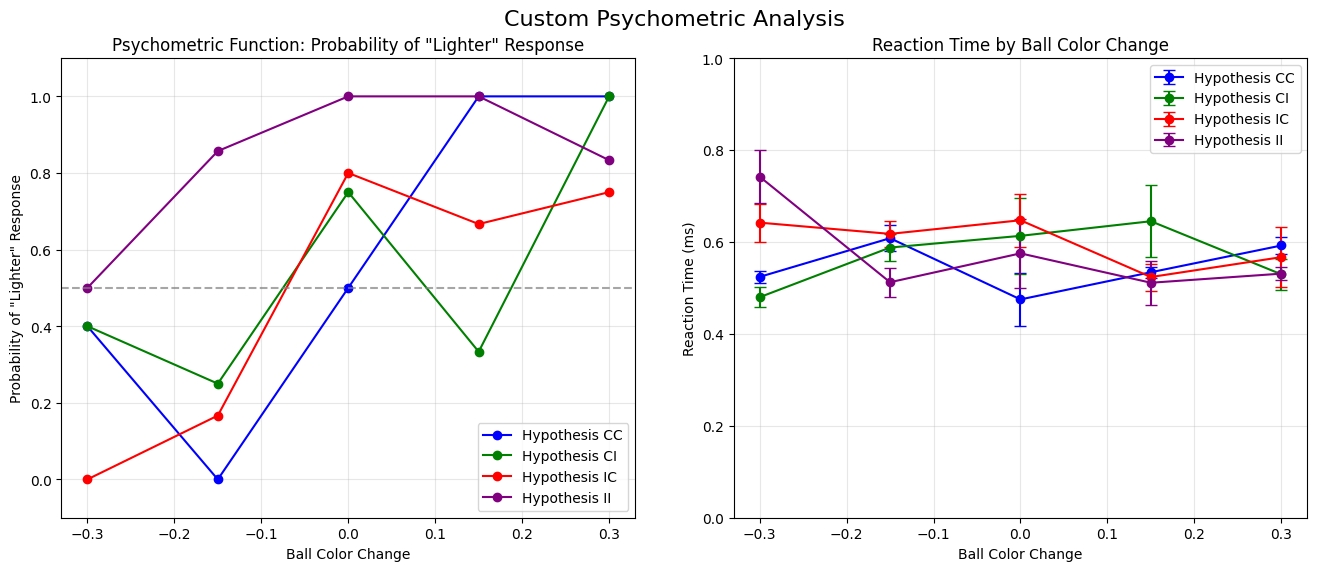

In [51]:

testdf = get_data(subject=None, task="ball_hue")
_ = create_psychometric_plots(data=testdf, 
                              title="Custom Psychometric Analysis", 
                              prob_ylim=(-.1, 1.1), 
                              rt_ylim=(0, 1), 
                              prob_poly_fit=None, 
                              rt_poly_fit=None,
                              split_hypotheses=True)

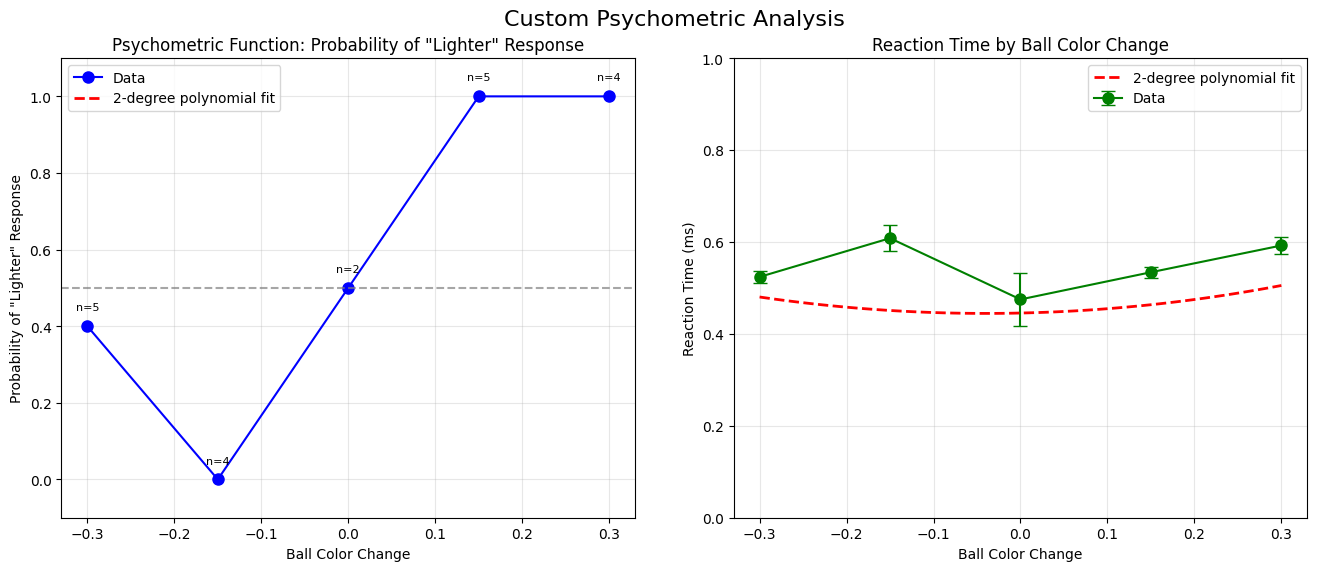

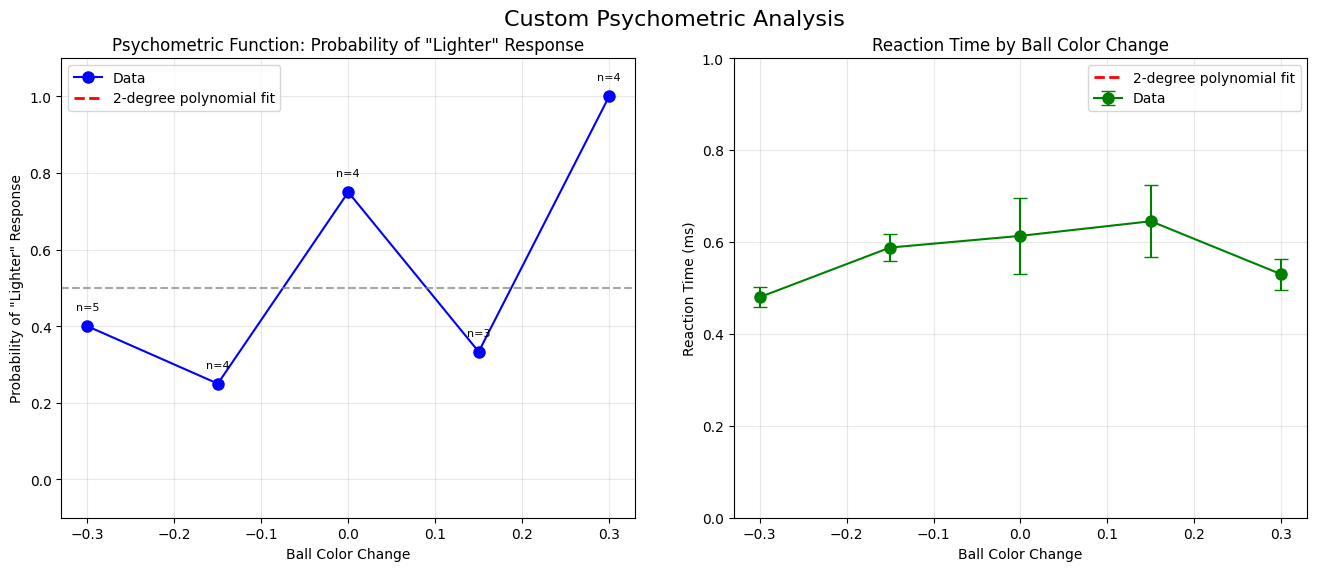

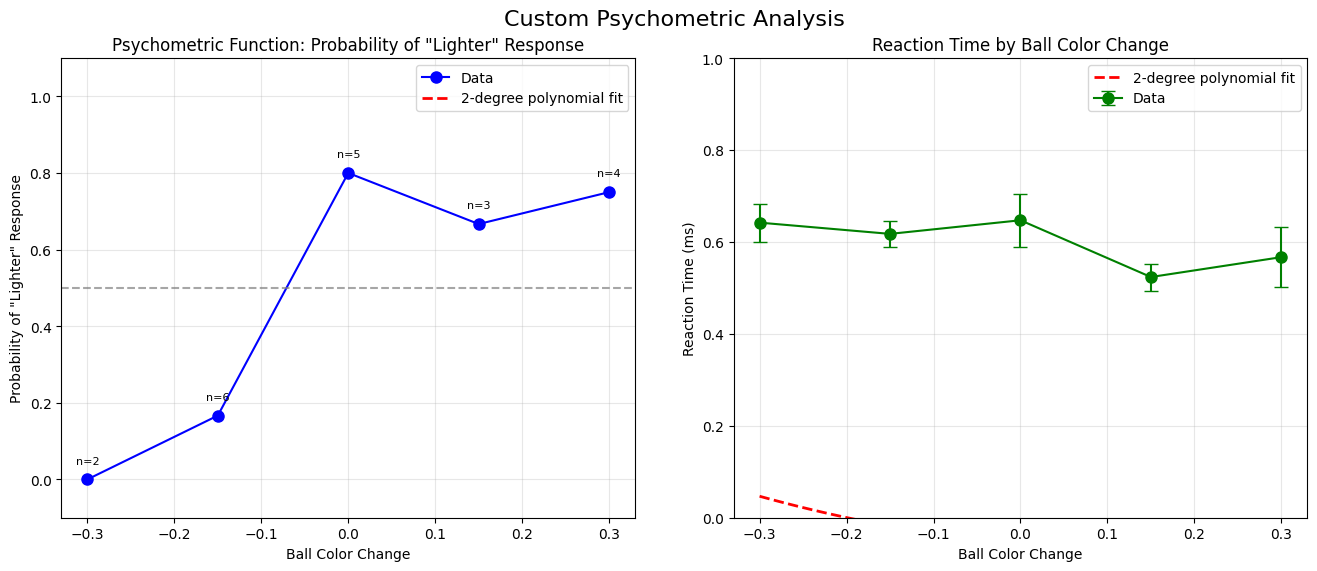

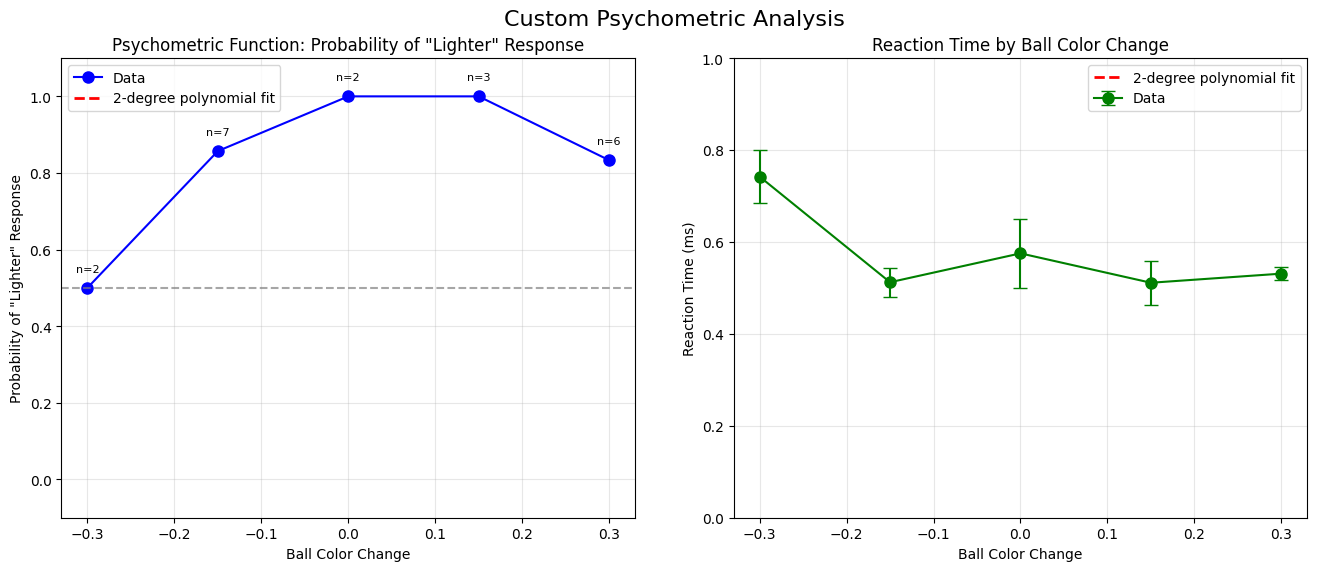

In [43]:

cc = filter_condition(testdf, True, True)
ci = filter_condition(testdf, True, False)
ic = filter_condition(testdf, False, True)
ii = filter_condition(testdf, False, False)

for df in [cc, ci, ic, ii]:
    _ = create_psychometric_plots(data=df, title="Custom Psychometric Analysis", prob_ylim=(-.1, 1.1), rt_ylim=(0, 1), prob_poly_fit=2, rt_poly_fit=2)

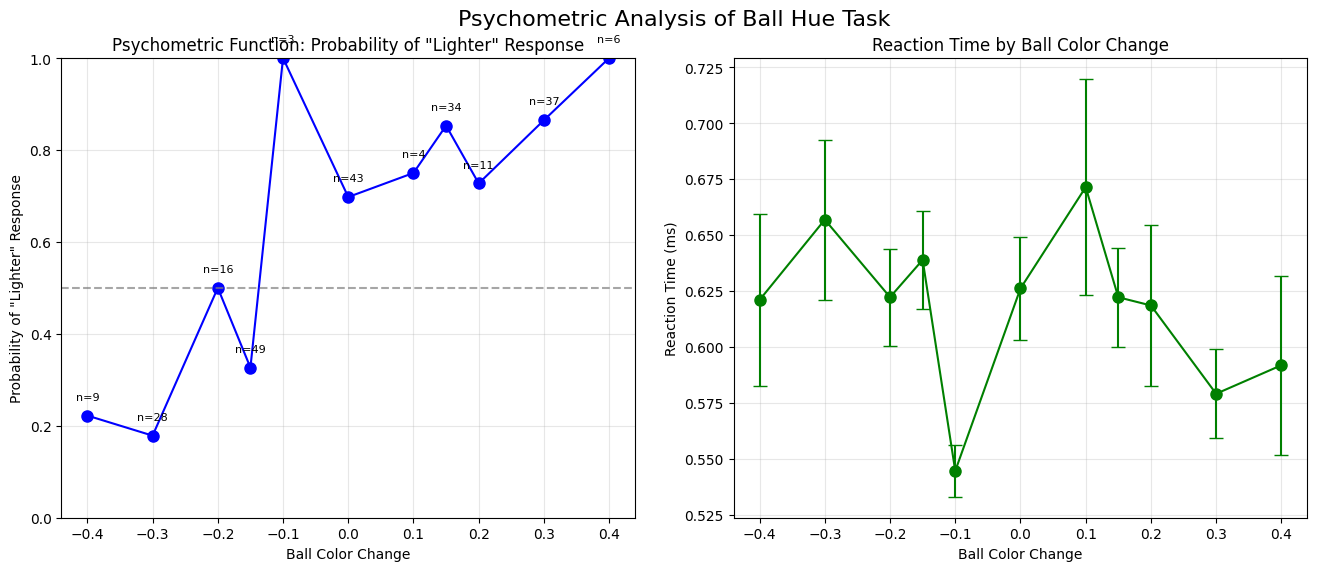

In [20]:
# Example usage:
# create_psychometric_plots(testdf)

# If you want to call this directly with your existing dataframe:
# If your dataframe is called 'testdf' and was loaded with:
# Then just call:



_ = create_psychometric_plots(testdf)

In [9]:
print(sub_stack['response'].unique())
estimator=lambda x: x.mean()
estimator=lambda x: (x.str.lower().str.strip() == 'lighter').mean()


['lighter' 'darker' 'space']


/var/folders/3n/yy1xjnlj5zd3nt4r1202183h0000gn/T/ipykernel_32284/1746886593.py:13: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 95)` for the same effect.

  sns.pointplot(
/var/folders/3n/yy1xjnlj5zd3nt4r1202183h0000gn/T/ipykernel_32284/1746886593.py:13: UserWarning: 

The `join` parameter is deprecated and will be removed in v0.15.0.

  sns.pointplot(


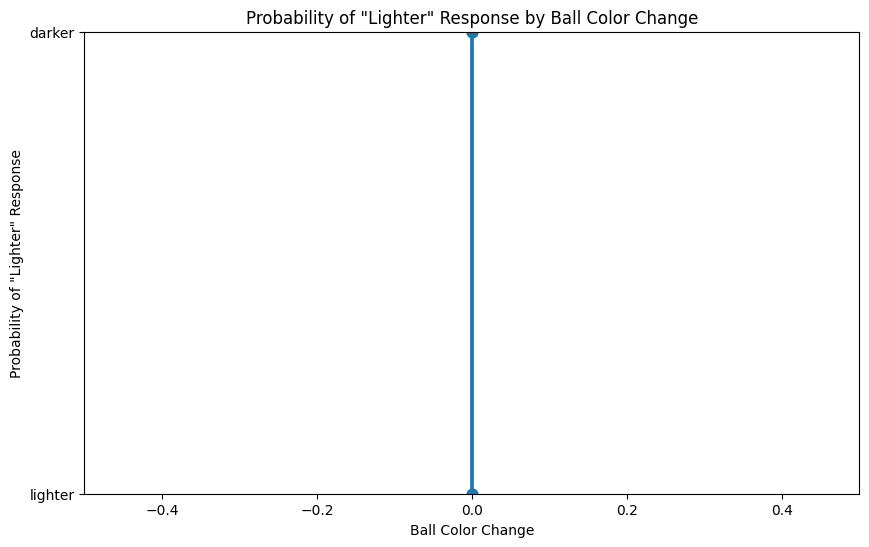

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Filter out NaN responses first
filtered_data = sub_stack.dropna(subset=['response'])

# Create a helper function for the estimator
def lighter_probability(x):
    return np.mean(x == "lighter")

plt.figure(figsize=(10, 6))
sns.pointplot(
    x='ball_color_change',
    y='response',
    data=filtered_data,
    estimator=lighter_probability,  # Use our custom estimator
    ci=95,
    join=True
)
plt.title('Probability of "Lighter" Response by Ball Color Change')
plt.xlabel('Ball Color Change')
plt.ylabel('Probability of "Lighter" Response')
plt.ylim(0, 1)
plt.xlim(-.5, .5)
plt.show()


In [32]:
np.mean(sub_stack["response"] == "lighter")

np.mean(sub_stack["response"] == "darker")

sub_stack["ball_color_change"] == .1

0     False
1     False
2     False
3     False
4     False
5      True
6     False
7      True
8     False
9     False
10     True
11    False
12    False
13    False
14    False
15    False
16    False
17    False
18    False
19    False
20    False
21    False
22    False
23    False
24    False
25    False
26    False
27    False
28    False
29    False
30    False
31    False
32    False
33    False
34    False
35    False
36    False
37    False
38    False
39    False
Name: ball_color_change, dtype: bool

ValueError: cannot convert float NaN to integer

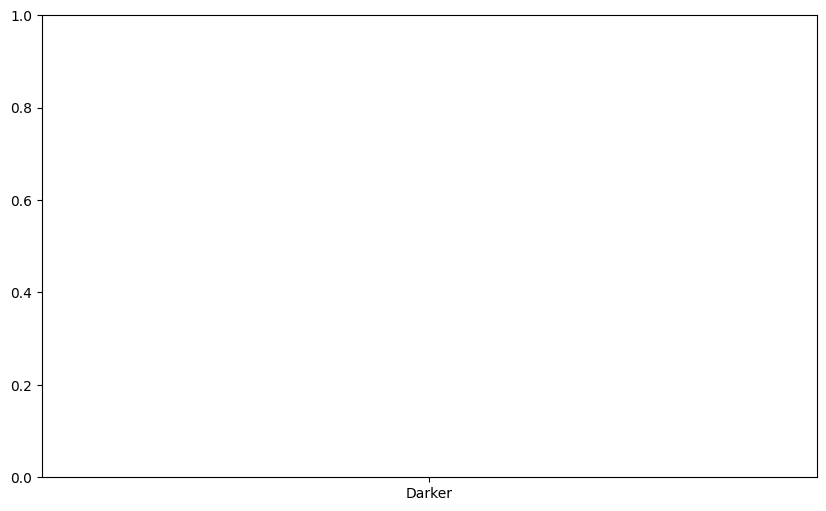

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

# First, let's create a function to categorize the ball_color_change values
def categorize_change(value):
    if value < 0:
        return "Darker"
    elif value > 0:
        return "Lighter"
    else:
        return "No Change"

# Apply this categorization to our data
# sub_stack['change_category'] = sub_stack['ball_color_change'].apply(categorize_change)

# Filter out NaN responses
filtered_data = sub_stack.dropna(subset=['response'])

# Calculate probabilities
prob_df = filtered_data.groupby('ball_color_change')['response'].agg(
    lighter_prob = lambda x: np.mean(x == "lighter"),
    darker_prob = lambda x: np.mean(x == "darker")
).reset_index()

# Sort the categories in a logical order
category_order = ["Darker", "No Change", "Lighter"]
prob_df['ball_color_change'] = pd.Categorical(prob_df['ball_color_change'], categories=category_order, ordered=True)
prob_df = prob_df.sort_values('ball_color_change')

# Plot
plt.figure(figsize=(10, 6))
sns.pointplot(
    x='ball_color_change',
    y='lighter_prob',
    data=prob_df,
    color='skyblue',
    label='Lighter Response'
)
sns.pointplot(
    x='ball_color_change',
    y='darker_prob',
    data=prob_df,
    color='salmon',
    label='Darker Response'
)
plt.title('Response Probabilities by Ball Color Change Category')
plt.xlabel('Ball Color Change Category')
plt.ylabel('Probability')
plt.ylim(0, 1)
plt.legend()
plt.show()

# Print the probability dataframe for reference
print(prob_df)


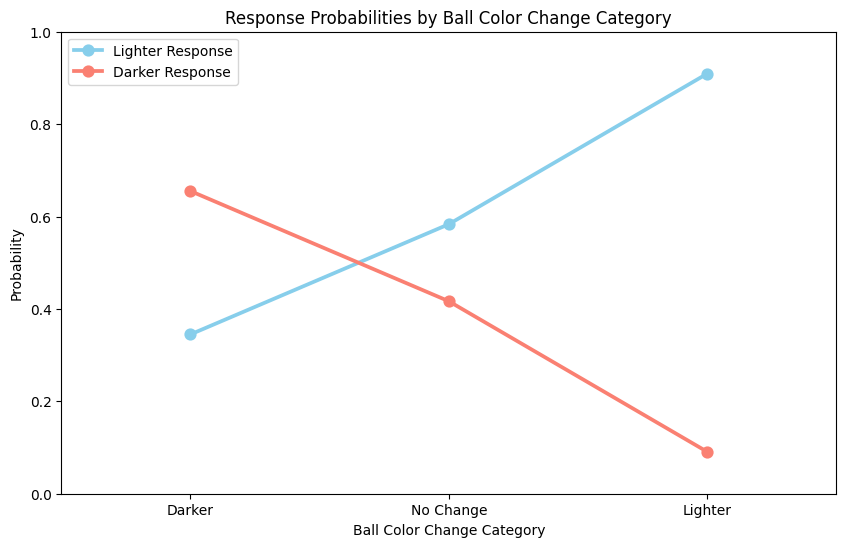

  change_category  lighter_prob  darker_prob
0          Darker      0.344828     0.655172
2       No Change      0.583333     0.416667
1         Lighter      0.909091     0.090909


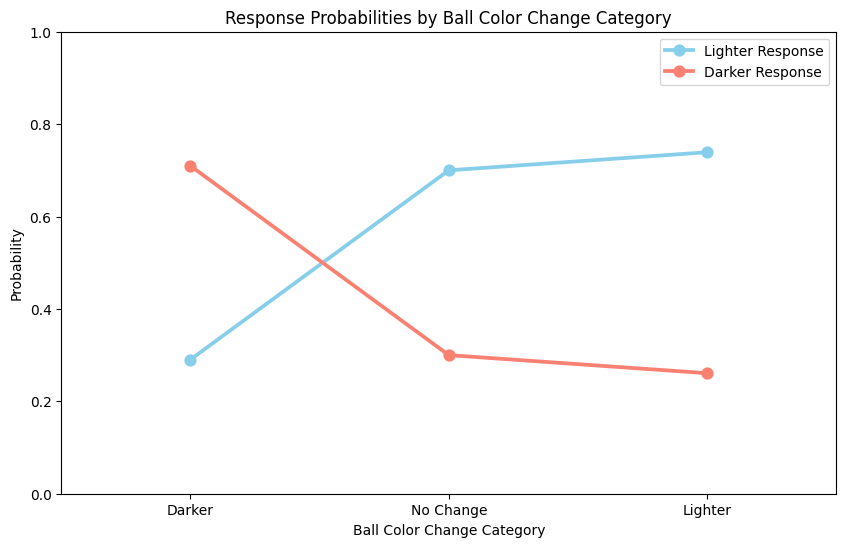

  change_category  lighter_prob  darker_prob
0          Darker      0.290323     0.709677
2       No Change      0.700000     0.300000
1         Lighter      0.739130     0.260870


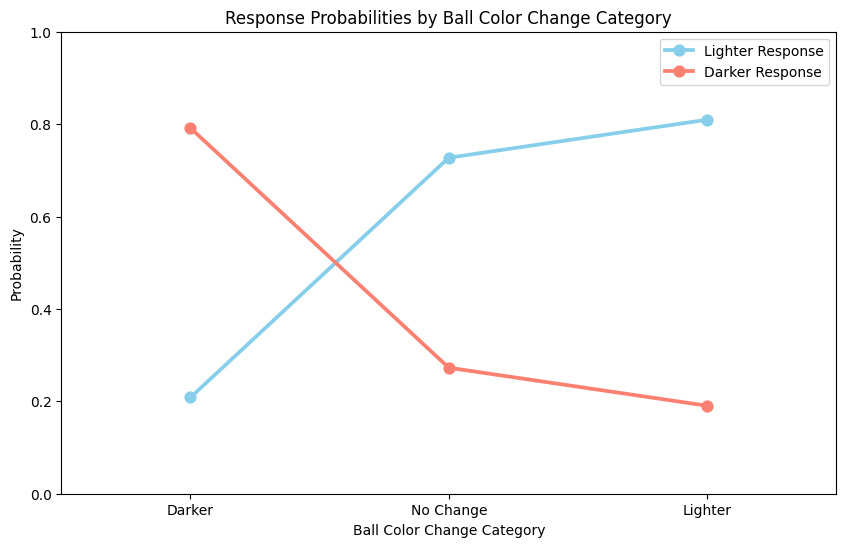

  change_category  lighter_prob  darker_prob
0          Darker      0.208333     0.791667
2       No Change      0.727273     0.272727
1         Lighter      0.809524     0.190476


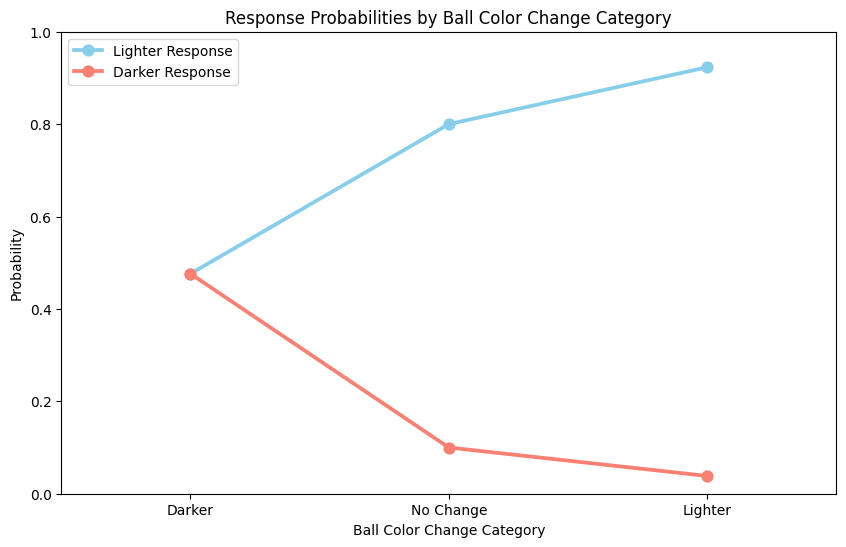

  change_category  lighter_prob  darker_prob
0          Darker      0.476190     0.476190
2       No Change      0.800000     0.100000
1         Lighter      0.923077     0.038462


In [37]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
def simple_probplot(data):
    # First, let's create a function to categorize the ball_color_change values
    def categorize_change(value):
        if value < 0:
            return "Darker"
        elif value > 0:
            return "Lighter"
        else:
            return "No Change"

    # Apply this categorization to our data
    data['change_category'] = data['ball_color_change'].apply(categorize_change)

    # Filter out NaN responses
    filtered_data = data.dropna(subset=['response'])

    # Calculate probabilities
    prob_df = filtered_data.groupby('change_category')['response'].agg(
        lighter_prob = lambda x: np.mean(x == "lighter"),
        darker_prob = lambda x: np.mean(x == "darker")
    ).reset_index()

    # Sort the categories in a logical order
    category_order = ["Darker", "No Change", "Lighter"]
    prob_df['change_category'] = pd.Categorical(prob_df['change_category'], categories=category_order, ordered=True)
    prob_df = prob_df.sort_values('change_category')

    # Plot
    plt.figure(figsize=(10, 6))
    sns.pointplot(
        x='change_category',
        y='lighter_prob',
        data=prob_df,
        color='skyblue',
        label='Lighter Response'
    )
    sns.pointplot(
        x='change_category',
        y='darker_prob',
        data=prob_df,
        color='salmon',
        label='Darker Response'
    )
    plt.title('Response Probabilities by Ball Color Change Category')
    plt.xlabel('Ball Color Change Category')
    plt.ylabel('Probability')
    plt.ylim(0, 1)
    plt.legend()
    plt.show()

    # Print the probability dataframe for reference
    print(prob_df)


cc = filter_condition(testdf, True, True)
ci = filter_condition(testdf, True, False)
ic = filter_condition(testdf, False, True)
ii = filter_condition(testdf, False, False)

for df in [cc, ci, ic, ii]:
    simple_probplot(df)

/var/folders/3n/yy1xjnlj5zd3nt4r1202183h0000gn/T/ipykernel_32284/2933355570.py:11: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 95)` for the same effect.

  sns.pointplot(x='ball_color_change', y='response', data=sub_stack,
/var/folders/3n/yy1xjnlj5zd3nt4r1202183h0000gn/T/ipykernel_32284/2933355570.py:11: UserWarning: 

The `join` parameter is deprecated and will be removed in v0.15.0.

  sns.pointplot(x='ball_color_change', y='response', data=sub_stack,


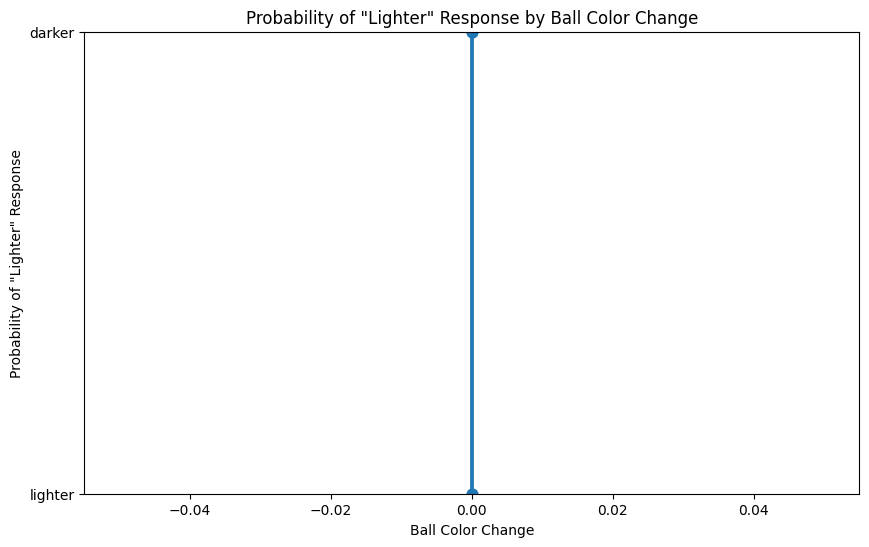

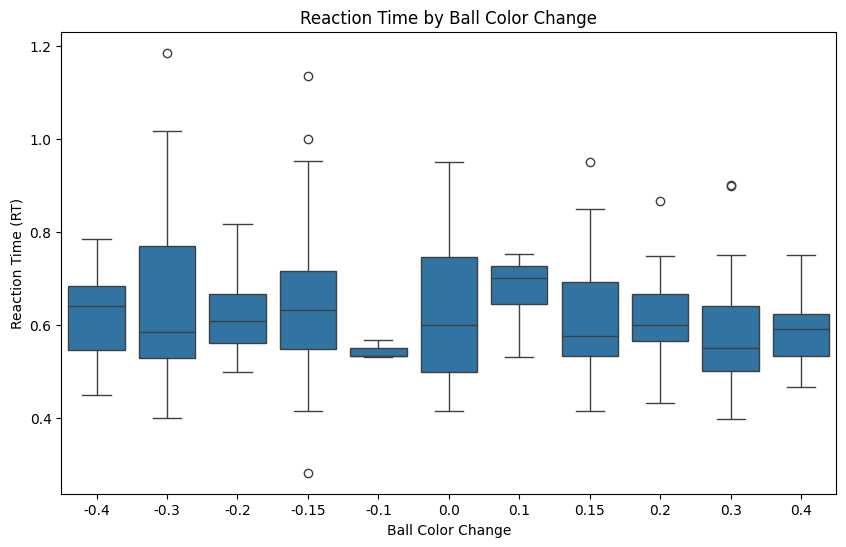

In [12]:
# Plot psychometric curve of the chance

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Assuming testdf is already loaded with your data

# Plot 1: Probability of "lighter" response
plt.figure(figsize=(10, 6))
sns.pointplot(x='ball_color_change', y='response', data=sub_stack, 
              estimator=lambda x: (x == 'darker').mean(),
              ci=95, join=True)
plt.title('Probability of "Lighter" Response by Ball Color Change')
plt.xlabel('Ball Color Change')
plt.ylabel('Probability of "Lighter" Response')
plt.ylim(0, 1)
plt.show()

# Plot 2: Reaction Time by Ball Color Change
plt.figure(figsize=(10, 6))
sns.boxplot(x='ball_color_change', y='rt', data=sub_stack)
plt.title('Reaction Time by Ball Color Change')
plt.xlabel('Ball Color Change')
plt.ylabel('Reaction Time (RT)')
plt.show()
